# Inversion of 2 by 2 matrices using an operator recurrent neural network

We use a simplified version of the network architecture proposed in the preprint

> Maarten V. de Hoop, Matti Lassas, Christopher A. Wong. _Deep learning architectures for nonlinear operator functions and nonlinear inverse problems_. [arXiv:1912.11090](https://arxiv.org/abs/1912.11090)

and teach it to invert matrices $X$ of the form $X = R D R^T$ where

$$
R = \begin{pmatrix}
c & -s
\\
s & c
\end{pmatrix},
\quad
D = \begin{pmatrix}
\lambda_1 & 0
\\
0 & \lambda_2
\end{pmatrix},
$$
$c = \cos(\alpha)$ and $s = \sin(\alpha)$ for some $\alpha \in (0,2\pi)$,
and $\lambda_j \in (1/2, 3/2)$, $j=1,2$.

We use notations as in version 3 of the preprint (revised 3 Jan 2022). The notation is different in earlier version.

In the code, variables have the same meaning as in the [Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) guige of PyTorch.

# Initialization

The operator recurrent architecture is implemented in `opnet` module, and 
generation of learning data in `simple_inversion_data`. 

File `PATH` is used to save the parameters of the network. 

In [4]:
import numpy as np
import torch
import os #help navigate files in folder
import matplotlib.pyplot as plt #plotting
import pandas as pd #data frames = nice table

import opnet
from simple_inversion_data import generate_data, save_data, load_data

#finding the best lr
#PATH1 = './simple_inversion_net22_1.pth'
#PATH2 = './simple_inversion_net22_2.pth'
#PATH3 = './simple_inversion_net22_3.pth'
#PATH4 = './simple_inversion_net22_4.pth'

#trained until limit point with lr=1e-1
#PATH = './simple_inversion_net_long.pth' 

#to compare relu and no relu
PATH1 = './simple_inversion_net_Relu.pth'
PATH2 = './simple_inversion_net_noRelu.pth'

#PATH = './simple_inversion_net22.pth' #can be overwritten
#PATH = './simple_inversion_net1.pth' #finding the best lr - trained with many learning rates
#PATH = './simple_inversion_net4.pth'
# PATH = './simple_inversion_netPlusMinusReLU.pth'
# PATH = './simple_inversion_netNEGA.pth'
# PATH = './simple_inversion_netReLU.pth'


Specify the network model and the loss function.

In [5]:

dim = 2 # use 2 x 2 matrices
num_layers = 5
# luodaan uusi neuroverkko
#model = opnet.OperatorNet(dim, 2*num_layers, useReLU=False)
#model = opnet.OperatorNet(dim, num_layers, useReLU=True) 
loss_fn = torch.nn.MSELoss()

# Generation of training data

Training data consists of pairs $(X,y)$ where $X$ is an invertible $2 \times 2$ matrix and $y = X^{-1} v$
where $v = (1,1) \in \mathbb{R}^2$.

In [6]:
#save_data(*generate_data(60000), "simple_inversion_train_dataPOSNEG.npz")
#save_data(*generate_data(10000), "simple_inversion_test_dataPOSNEG.npz")

train_data_path = "simple_inversion_train_data.npz"
test_data_path = "simple_inversion_test_data.npz"

# Training and Testing

In [7]:
import training_and_testing
import os.path

# update changes
from importlib import reload 
reload(training_and_testing)
reload(opnet)

lr = 1e-1
losses_list=[]
path_list = [PATH1, PATH2] #relu vs no relu
for path in path_list:
    if path == PATH1: #with relu
        model = opnet.OperatorNet(dim, num_layers, useReLU=True) 
        losses_list.append(training_and_testing.training_and_testing(model, loss_fn,lr, path, train_data_path, test_data_path))
    else: #no relu
        model = opnet.OperatorNet(dim, 2*num_layers, useReLU=False)
        losses_list.append(training_and_testing.training_and_testing(model, loss_fn,lr, path, train_data_path, test_data_path))
    

# # Liva:
# #lr_list = [1e-4, 1e-3, 1e-2, 1e-1]
# lr_list = [1e-2] #the best one
# losses_list=[]
# # same as below
# #upload the neural network used earlier:
# if os.path.exists(PATH):
#     print("Found an old path")
#     model.load_state_dict(torch.load(PATH))
# else:
#     print("No old path, creating a new one")
#     torch.save(model.state_dict(), PATH)
#     model.load_state_dict(torch.load(PATH))

# #calculates the average loss to the learning rate(s) above and adds a new row of avr loss into table
# for lr in lr_list:
#     losses_list.append(training_and_testing.training_and_testing(model, loss_fn,lr, PATH, train_data_path, test_data_path))
# #end-Liva


# lr=1e-1
# # upload the neural network used earlier:
# if os.path.exists(PATH):
#     model.load_state_dict(torch.load(PATH)) 
# else:
#     print("no old PATH, I'll make a new one")

# training_and_testing.training_and_testing(model, loss_fn, lr)

# #chech if network uses relu
# doesit = model.does_it_use_relu()
# #layer = model.layers[0].A
# #print("testi layer on ", layer)

# Load the training data
# train_loader = torch.utils.data.DataLoader(
#     load_data("simple_inversion_train_data.npz"), 
#     batch_size=64)

lr=  0.1
path=  ./simple_inversion_net_Relu.pth
2 0.001752
4 0.000701
6 0.000588
8 0.000542
10 0.000509
12 0.000481
14 0.000456
16 0.000434
18 0.000413
20 0.000391
22 0.000360
24 0.000335
26 0.000315
28 0.000298
30 0.000284
32 0.000272
34 0.000261
36 0.000252
38 0.000243
40 0.000235
42 0.000226
44 0.000218
46 0.000210
48 0.000203
50 0.000196
52 0.000189
54 0.000182
56 0.000175
58 0.000169
60 0.000162
62 0.000156
64 0.000150
66 0.000144
68 0.000138
70 0.000133
72 0.000127
74 0.000122
76 0.000116
78 0.000111
80 0.000107
82 0.000102
84 0.000097
86 0.000093
88 0.000089
lr=  0.1
path=  ./simple_inversion_net_noRelu.pth
2 0.003822
4 0.001828
6 0.001296
8 0.001091
10 0.000943
12 0.000820
14 0.000708
16 0.000604
18 0.000512
20 0.000435
22 0.000379
24 0.000342
26 0.000319
28 0.000303
30 0.000291
32 0.000283
34 0.000276
36 0.000270
38 0.000265
40 0.000260
42 0.000256
44 0.000252
46 0.000248
48 0.000244
50 0.000240
52 0.000236
54 0.000232
56 0.000229
58 0.000225
60 0.000222
62 0.000219
64 0.00021

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


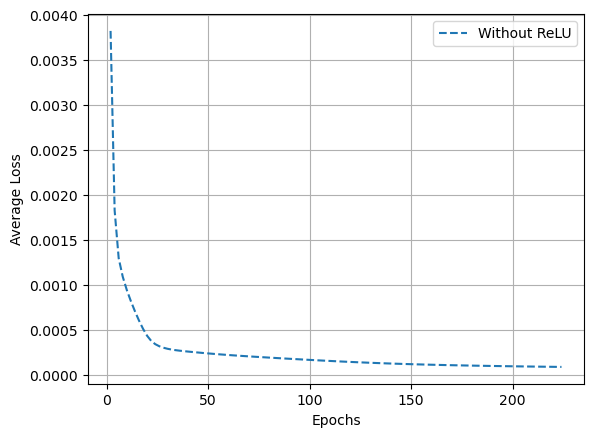

In [12]:
#Plotting
#Liva
# x-coordinates: HOW MANY YOU HAVE?!
# now from 2 to 20 and every other
#epo = np.arange(0,20,2)+2
epo = np.arange(0,224,2)+2
#print(epo)

# plot the figure
from matplotlib.lines import lineStyles
#plt.plot(epo, losses_list[0], label = 'With ReLU', linestyle='--')
plt.plot(epo, losses_list[1], label = 'Without ReLU', linestyle='--')
#plt.plot(epo, losses_list[2], label = 'Network 3', linestyle='--')
#plt.plot(epo, losses_list[3], label = 'Network 4', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.grid()
plt.legend()
plt.savefig("../masters-thesis/data/matrix-seelearning281122_relu_vs_norelu2.eps", format="eps") #save as eps so it's easy to insert it to latex-file

In [16]:

index_x = [f"{e} epochs" for e in epo]
index_y = ["With ReLU","Without ReLU"]
df1 = pd.DataFrame(losses_list, columns=index_x, index = index_y)
df1.index.name = "Network"
# saves the table in latex-code
df1.to_latex("../masters-thesis/data/matrix-seelearning281122_relu_vs_norelu.tex", columns=[f"{e} epochs" for e in [10, 50, 88, 180, 224]])
# saves the table in csv-form
df1.to_csv("../masters-thesis/data/matrix-seelearning281122_relu_vs_norelu.csv", index=True, sep=";", decimal=",") #sep=separates columns, decimal=uses , instead of .
df1

C:\Users\Aili\AppData\Local\Temp\ipykernel_3928\244236254.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df1.to_latex("../masters-thesis/data/matrix-seelearning281122_relu_vs_norelu.tex", columns=[f"{e} epochs" for e in [10, 50, 88, 180, 224]])


,2 epochs,4 epochs,6 epochs,8 epochs,10 epochs,12 epochs,14 epochs,16 epochs,18 epochs,20 epochs,...,206 epochs,208 epochs,210 epochs,212 epochs,214 epochs,216 epochs,218 epochs,220 epochs,222 epochs,224 epochs
Network,,,,,,,,,,,,,,,,,,,,,
With ReLU,0.001752,0.000701,0.000588,0.000542,0.000509,0.000481,0.000456,0.000434,0.000413,0.000391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Without ReLU,0.003822,0.001828,0.001296,0.001091,0.000943,0.000820,0.000708,0.000604,0.000512,0.000435,...,0.000095,0.000094,0.000094,0.000093,0.000092,0.000092,0.000091,0.000091,0.00009,0.00009
